## HERE geocoding API

Works with [HERE Geocoding and Search API](https://developer.here.com/documentation/geocoding-search-api/api-reference-swagger.html).

Free limit is 250k requests per month, you have to get an API key to replicate the process.

[Open data about housing](https://www.reformagkh.ru/opendata?gid=2353101&cids=house_management&page=1&pageSize=10) is used for the example. 

In [7]:
import pandas as pd
import requests

import geopandas as gpd
from pyproj import CRS
from shapely import wkt

import matplotlib.pyplot as plt
import contextily as ctx

import warnings
warnings.filterwarnings("ignore")

In [8]:
# reading api keys
api_keys = pd.read_excel('../api_keys.xlsx')
api_keys.set_index('key_name', inplace=True)

# HERE Rest api key
here_api_key = api_keys.loc['here_rest_api']['key']

In [9]:
# importing housing data
tab = pd.read_csv('./input_data/opendata_reform_tatarstan.csv', sep = ';')

# selecting a city with a number of houses within our geocoder limit
df_sample = tab[tab['formalname_city']=='Альметьевск']
len(df_sample)

962

In [10]:
URL = 'https://geocode.search.hereapi.com/v1/geocode'

In [11]:
# retrieving the coordinates in wkt format

def here_geocoder(address):
    params = { 
        'apiKey': here_api_key,
        'in': 'countryCode:RUS',
        'q': address,
            }
    
    # response
    response = requests.get(URL, params=params)
    response_json = response.json()
    try:
        lat = response_json['items'][0]['position']['lat']
        lng = response_json['items'][0]['position']['lng']
        
        wkt_point = 'POINT ({} {})'.format(lng,lat)
        
        return wkt_point
    except Exception as e:
        print("for address", address)
        print("result is", response_json)
        print("which raises", e)
        return ""

In [12]:
df_sample['coords'] = df_sample['address'].apply(here_geocoder)

In [13]:
# shapely wkt submodule to parse wkt format

def wkt_loads(x):
    try:
        return wkt.loads(x)
    except Exception:
        return None
    
df_sample['coords_wkt'] = df_sample['coords'].apply(wkt_loads)
df_sample = df_sample.dropna(subset=['coords_wkt'])

print ('Number of geocoded houses - ', len(df_sample))

Number of geocoded houses -  962


In [14]:
# transform to geodataframe
housing_sample = gpd.GeoDataFrame(df_sample, geometry='coords_wkt')
housing_sample = housing_sample.set_crs(epsg=4326)

In [18]:
# write the result to Shapefile
housing_sample.to_file('./input_data/2housing_test.shp')

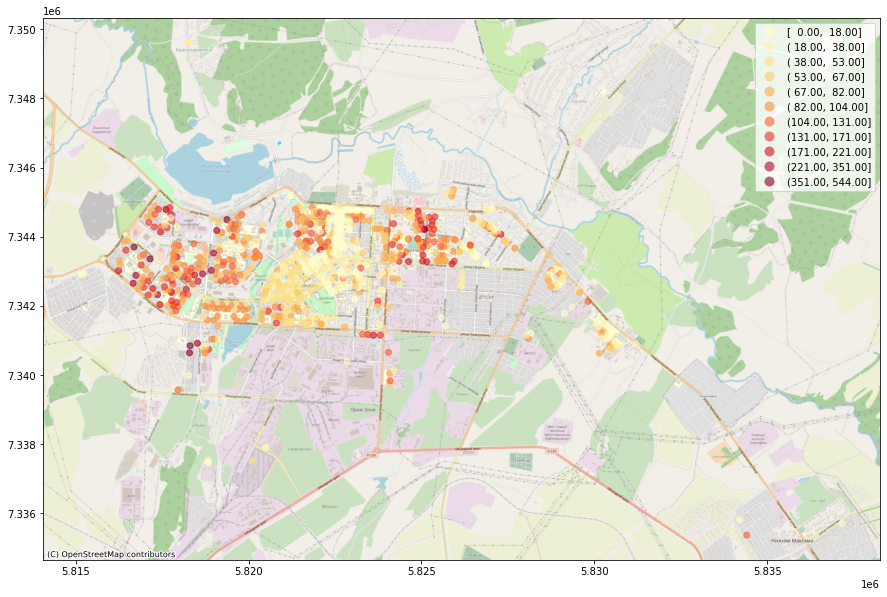

In [23]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(15,15))

# Plot the data with color based on quarters count
housing_sample.to_crs(epsg=3857).plot(ax=ax, column='quarters_count', cmap='YlOrRd',
                            scheme="Natural_Breaks", k=11, alpha=0.6, legend=True)

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)